# Predicting T1D using Machine Learning Algorithms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
#import shap

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Data Preprocessing

In [ ]:
# load dataset and labels
data_file_path = "diabetes_Dataset_Team_ML.csv"
labels_file_path = "Diabetes_T1_labels.txt"
data = pd.read_csv(data_file_path)
labels = pd.read_csv(labels_file_path, delimiter='\t')

In [ ]:
print((data['Ancestry_British'].unique()))

[1. 0.]


In [ ]:
# preview dataset
print(data.head())

        ID  Ancestry_African  Ancestry_Any other Asian background  \
0  5713894               0.0                                  0.0   
1  2048882               0.0                                  0.0   
2  1748132               0.0                                  0.0   
3  3772083               0.0                                  0.0   
4  4376107               0.0                                  0.0   

   Ancestry_Any other Black background  Ancestry_Any other mixed background  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   Ancestry_Any other white background  Ancestry_Asian or Asian British  \
0                                  

In [ ]:
# preview labels
print(labels.head())

    UKB ID  time_window_incident/nan/1.0/nan/av1  \
0  5713894                                   0.0   
1  2048882                                   0.0   
2  1748132                                   0.0   
3  3772083                                   0.0   
4  4376107                                   0.0   

   time_window_incident/nan/2.0/nan/av1  time_window_incident/nan/3.0/nan/av1  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   time_window_incident/nan/4.0/nan/av1  time_window_incident/nan/5.0/nan/av1  \
0                                   0.0                                   0.0   
1                                   0.

In [ ]:
# filter for british ancestry
data = data[data['Ancestry_British'] != 0]

In [ ]:
print(len(data))

442574


In [ ]:
# how many british ancestry patients
int(data['Ancestry_British'].sum())

442574

In [ ]:
# drop nan values from data
data = data.dropna()

In [ ]:
# join dataset based on patient ids
# use left join to keep filtered data
joined_data = pd.merge(data, labels[['UKB ID', 'time_window_incident/nan/10.0/nan/av1']], left_on='ID', right_on='UKB ID', how='left')

In [ ]:
# drop ukb id column
joined_data = joined_data.drop(columns=['UKB ID'])

In [ ]:
# drop nan values
joined_data = joined_data.dropna(subset=['time_window_incident/nan/10.0/nan/av1'])

In [ ]:
# list of joined dataset columns
print(list(joined_data.columns))

['ID', 'Ancestry_African', 'Ancestry_Any other Asian background', 'Ancestry_Any other Black background', 'Ancestry_Any other mixed background', 'Ancestry_Any other white background', 'Ancestry_Asian or Asian British', 'Ancestry_Bangladeshi', 'Ancestry_Black or Black British', 'Ancestry_British', 'Ancestry_Caribbean', 'Ancestry_Chinese', 'Ancestry_Do not know', 'Ancestry_Indian', 'Ancestry_Irish', 'Ancestry_Mixed', 'Ancestry_Other ethnic group', 'Ancestry_Pakistani', 'Ancestry_Prefer not to answer', 'Ancestry_White', 'Ancestry_White and Asian', 'Ancestry_White and Black African', 'Ancestry_White and Black Caribbean', 'f.21022.0.0', 'f.21001.0.0', 'f.904.0.0', 'f.904.0.0_Do not know', 'f.904.0.0_Prefer not to answer', 'f.20107_Father_Lung cancer', 'f.20107_Father_Bowel cancer', 'f.20107_Father_Prostate cancer', 'f.20107_Father_High blood pressure', 'f.20107_Father_Diabetes', 'f.20110_Mother_Lung cancer', 'f.20110_Mother_Bowel cancer', 'f.20110_Mother_Breast cancer', 'f.20110_Mother_High 

In [ ]:
# dict mapping original column names to their descriptive names
column_renames = {
    'f.21022.0.0': 'Age',
    'f.21001.0.0': 'BMI',
    'f.20107_Father_Diabetes': 'Father has diabetes',
    'f.20110_Mother_Diabetes': 'Mother has diabetes',
    'f.20116.0.0_Current': 'Current smoker',
    'f.20116.0.0_Previous': 'Former smoker',
    'f.20116.0.0_Never': 'Never smoker',
    'f.6155_Vitamin D': 'Vitamin D',
    'f.6145_Death of a close relative': 'Death of family member',
    'f.6145_Serious illness, injury or assault to yourself': 'Serious illness, injury or assault to yourself',
    'f.6145_Serious illness, injury or assault of a close relative': 'Serious illness, injury or assault of a close relative',
    'f.6145_Financial difficulties': 'Financial difficulties',
    'f.6145_Marital separation/divorce': 'Marital separation/divorce',
    'f.6145_Death of a spouse or partner': 'Death of a spouse or partner'
}


In [ ]:
# only keep renamed columns in dataframe
filtered_joined_data = joined_data[list(column_renames.keys())]
print(list(filtered_joined_data.columns))

['f.21022.0.0', 'f.21001.0.0', 'f.20107_Father_Diabetes', 'f.20110_Mother_Diabetes', 'f.20116.0.0_Current', 'f.20116.0.0_Previous', 'f.20116.0.0_Never', 'f.6155_Vitamin D', 'f.6145_Death of a close relative', 'f.6145_Serious illness, injury or assault to yourself', 'f.6145_Serious illness, injury or assault of a close relative', 'f.6145_Financial difficulties', 'f.6145_Marital separation/divorce', 'f.6145_Death of a spouse or partner']


In [ ]:
# rename columns
filtered_joined_data = filtered_joined_data.rename(columns=column_renames)

In [ ]:
# create family history feature

# combine 'Father has diabetes' and 'Mother has diabetes' into 'Family history'
filtered_joined_data['Family history'] = ((filtered_joined_data['Father has diabetes'] == 1) | (filtered_joined_data['Mother has diabetes'] == 1)).astype(int)

# drop the original parent diabetes columns
filtered_joined_data = filtered_joined_data.drop(columns=['Father has diabetes', 'Mother has diabetes'])

In [ ]:
# create stress feature

stress_columns = [
    'Death of family member',
    'Serious illness, injury or assault to yourself',
    'Serious illness, injury or assault of a close relative',
    'Financial difficulties',
    'Marital separation/divorce',
    'Death of a spouse or partner'
]

# combine all stress columns in one binary feature
filtered_joined_data['stress'] = filtered_joined_data[stress_columns].max(axis=1).astype(int)

# drop the original individual stress columns
filtered_joined_data = filtered_joined_data.drop(columns=stress_columns)

In [ ]:
# create smoking feature

# 1 for current smokers, 0 for former smokers, -1 for never smokers
filtered_joined_data['smoking'] = filtered_joined_data.apply(
    lambda row: 1 if row['Current smoker'] == 1 else (0 if row['Former smoker'] == 1 else -1), axis=1
).astype(int)

# drop the original smoking related columns
filtered_joined_data = filtered_joined_data.drop(columns=['Current smoker', 'Never smoker', 'Former smoker'])


In [ ]:
# scaling age and bmi
scaler = StandardScaler()
filtered_joined_data[['Age', 'BMI']] = scaler.fit_transform(filtered_joined_data[['Age', 'BMI']])

In [ ]:
# convert the vitamin d column to integers
filtered_joined_data['Vitamin D'] = filtered_joined_data['Vitamin D'].astype(int)

In [ ]:
# add target column to dataframe
filtered_joined_data['target'] = joined_data['time_window_incident/nan/10.0/nan/av1'].astype(int)

# verify dataframe changes
print(filtered_joined_data.head())

        Age       BMI  Vitamin D  Family history  stress  smoking  target
0  0.420274  1.469922          0               0       1       -1       0
1 -0.329812 -1.003657          1               1       1       -1       0
2  0.920330 -0.885162          0               0       0       -1       0
3 -1.204911 -0.808987          0               0       0       -1       0
4  1.420387 -0.574113          0               0       1       -1       0


In [ ]:
# how many patients have T1D
label_counts = filtered_joined_data['target'].value_counts()
print(label_counts)

target
0    303003
1      1991
Name: count, dtype: int64


In [ ]:
# train test split

# seperate features and target
X = filtered_joined_data.drop(columns=['target'])
y = filtered_joined_data['target']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [ ]:
# # scaling age and bmi
# scaler = StandardScaler()
# X_train[['age', 'BMI']] = scaler.fit_transform(X_train[['Age', 'BMI']])
# X_test[['age', 'BMI']] = scaler.transform(X_test[['Age', 'BMI']])

In [ ]:
# # address class imbalance

# # apply smote
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # check values after smote
# print("class distribution after smote:")
# print(pd.Series(y_train_resampled).value_counts())

class distribution after smote:
target
0    375315
1    375315
Name: count, dtype: int64


## Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=300, random_state=42)

In [ ]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_prob))

Accuracy: 0.708608837255052
Confusion Matrix:
 [[64440 26462]
 [  200   397]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83     90902
           1       0.01      0.66      0.03       597

    accuracy                           0.71     91499
   macro avg       0.51      0.69      0.43     91499
weighted avg       0.99      0.71      0.82     91499

AUC:
 0.7484898972873653


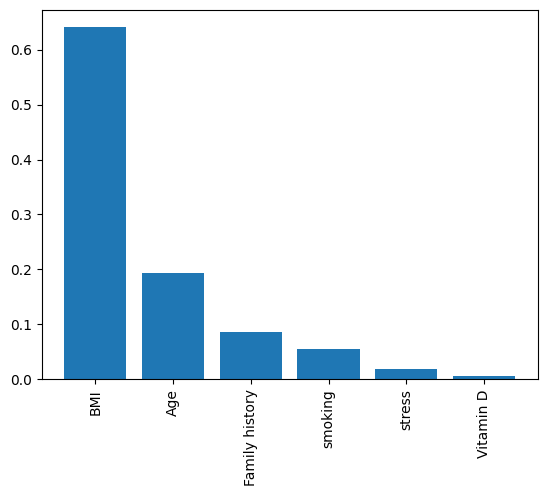

In [ ]:
# check feature importance
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.show()

##Decision Tree

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [ ]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

In [ ]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, random_state=42)

In [ ]:
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)[:, 1]

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_prob))

Accuracy: 0.6563131837506421
Confusion Matrix:
 [[59630 31272]
 [  175   422]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79     90902
           1       0.01      0.71      0.03       597

    accuracy                           0.66     91499
   macro avg       0.51      0.68      0.41     91499
weighted avg       0.99      0.66      0.79     91499

AUC:
 0.7343731337007436


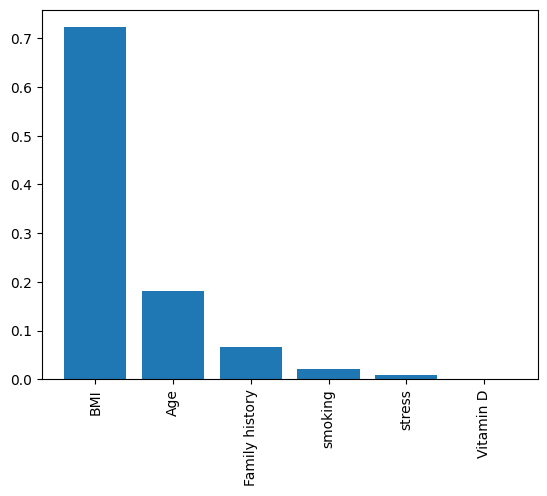

In [ ]:
# Feature Importance
feature_importances = dt.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.show()

In [ ]:
# Define the parameter grid
param_dist = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Initialize a Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist, \
    n_iter=20,                 # Number of random combinations to try
    cv=5,                      # Number of cross-validation folds
    scoring='roc_auc',         # Scoring metric
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params_random = random_search.best_params_
best_dt_model_random = random_search.best_estimator_
print("Best Parameters (Randomized Search):", best_params_random)

# Evaluate the best model
y_pred_random = best_dt_model_random.predict(X_test)
y_prob_random = best_dt_model_random.predict_proba(X_test)[:, 1]

print("Best Model Accuracy (Randomized Search):", accuracy_score(y_test, y_pred_random))
print("Best Model AUC (Randomized Search):", roc_auc_score(y_test, y_prob_random))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters (Randomized Search): {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5, 'class_weight': {0: 1, 1: 5}}
Best Model Accuracy (Randomized Search): 0.99347533852829
Best Model AUC (Randomized Search): 0.7264183524237838
